In [1]:
import os
import pandas as pd
import nibabel as nib
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from skimage.measure import block_reduce
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# File path to the CSV file
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)
# Remove rows where ADAS11_bl is missing (NaN)
df_cleaned = df.dropna(subset=['ADAS11_bl'])

# Extract the 'ADAS11_bl' column as the y variable
y_variable = df_cleaned['ADAS11_bl'].values

# Split the dataframe based on the DX_bl column values
cn_group = df_cleaned[df_cleaned['DX_bl'] == 'CN']
ad_group = df_cleaned[df_cleaned['DX_bl'] == 'AD']
lmci_group = df_cleaned[df_cleaned['DX_bl'] == 'LMCI']

# Display the counts for each group after removing NA
print(f"CN group size: {cn_group.shape[0]}")
print(f"AD group size: {ad_group.shape[0]}")
print(f"LMCI group size: {lmci_group.shape[0]}")

# Directory containing the 3D images
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize dictionaries to hold the images and y values for each group
cn_images, ad_images, lmci_images = [], [], []
cn_y, ad_y, lmci_y = [], [], []

# Function to load the images based on PTID matching and append y values
def load_images_and_y(group, image_list, y_list):
    for _, row in group.iterrows():
        ptid = row['PTID']
        # Find the corresponding file based on PTID
        filename = f'{ptid}.nii.gz'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            # Load the NIfTI file
            img = nib.load(file_path)
            data = img.get_fdata()
            
            # Append the 3D image data and y value to the respective lists
            image_list.append(data)
            y_list.append(row['ADAS11_bl'])
        else:
            print(f"File {filename} not found.")

# Load images and y values for each group
load_images_and_y(cn_group, cn_images, cn_y)
load_images_and_y(ad_group, ad_images, ad_y)
load_images_and_y(lmci_group, lmci_images, lmci_y)

# Convert lists of 3D images and y values to NumPy arrays
if cn_images:
    cn_tensor = np.stack(cn_images, axis=0)
    cn_y = np.array(cn_y)
    print(f"CN 4D tensor shape: {cn_tensor.shape}")
    print(f"CN y shape: {cn_y.shape}")
else:
    print("No CN images loaded.")

if ad_images:
    ad_tensor = np.stack(ad_images, axis=0)
    ad_y = np.array(ad_y)
    print(f"AD 4D tensor shape: {ad_tensor.shape}")
    print(f"AD y shape: {ad_y.shape}")
else:
    print("No AD images loaded.")

if lmci_images:
    lmci_tensor = np.stack(lmci_images, axis=0)
    lmci_y = np.array(lmci_y)
    print(f"LMCI 4D tensor shape: {lmci_tensor.shape}")
    print(f"LMCI y shape: {lmci_y.shape}")
else:
    print("No LMCI images loaded.")

CN group size: 229
AD group size: 187
LMCI group size: 401
CN 4D tensor shape: (229, 48, 48, 48)
CN y shape: (229,)
AD 4D tensor shape: (187, 48, 48, 48)
AD y shape: (187,)
LMCI 4D tensor shape: (401, 48, 48, 48)
LMCI y shape: (401,)


In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import cholesky, inv
import math
import time
from functools import reduce
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.special import gammaln, logsumexp
from sklearn.linear_model import LassoCV
import itertools
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import geninvgauss

def getouter_list(bet):
    d = len(bet)
    if d == 1:
        return bet[0]
    elif d == 2:
        return np.outer(bet[0], bet[1]).reshape(bet[0].shape + bet[1].shape)
    else:
        return np.outer(getouter_list(bet[:-1]), bet[-1]).reshape(getouter_list(bet[:-1]).shape + bet[-1].shape)

def getmean(X, beta, rank, rank_exclude=None):
    if rank_exclude is None:
        rank_exclude = []

    idx = [i for i in range(rank) if i not in rank_exclude]
    B_list = [getouter_list([beta_elem[r, :] for beta_elem in beta]) for r in idx]
    B = reduce(lambda x, y: x + y, B_list)
    def compute_sum(xx, bb):
        return np.sum(xx * bb)
    mu_B = np.array([compute_sum(xx, B) for xx in X])
    return mu_B

def logsum(lx):
    max_lx = np.max(lx)
    return max_lx + np.log(np.sum(np.exp(lx - max_lx)))

def TP_rankR(X_allr):
    R = X_allr[0].shape[1] if len(X_allr[0].shape) > 1 else None
    if R is None:
        return getouter_list(X_allr)
    else:
        dims = [x.shape[0] for x in X_allr]
        Y = np.zeros(dims)
        for r in range(R):
            outer_results = [x[:, r] for x in X_allr]
            Y += getouter_list(outer_results)
        return Y

def getBeta_mcmc(beta_store):
    nsweep = len(beta_store)
    d = len(beta_store[0])
    rank = beta_store[0][0].shape[0]
    p = [beta_store[0][x].shape[1] for x in range(d)]
    Beta_mcmc = np.zeros((nsweep, np.prod(p)))
    
    for i in range(nsweep):
        coef = np.zeros(np.prod(p))
        for r in range(rank):
            outer_list = [beta_store[i][x][r, :] for x in range(d)]
            coef += getouter_list(outer_list).flatten()
        Beta_mcmc[i, :] = coef    
    return Beta_mcmc

####main function####
def tensor_reg(z_train, x_train, y_train, a_lam, b_lam, phi_alpha, nsweep=1e3, rank=5, burn=0.30,
               nskip=3, scale=True, plot=False):
    
    
    n = len(y_train)
    p = x_train.shape[1:]
    d = len(x_train.shape)-1
    pgamma = z_train.shape[1]
    

    #### standarize ####
    my = np.mean(y_train)
    sy = np.std(y_train, ddof=1) if scale else 1
    if scale:
        obs = (y_train - my) / sy
    else:
        obs = y_train
    if scale:
        mz = np.mean(z_train, axis=0)
        sz = np.array([np.max(z_train[:, i]) - np.min(z_train[:, i]) for i in range(pgamma)])
        sz[sz==0] = 1
        Zt = np.zeros_like(z_train, dtype=float)
        for jj in range(pgamma):
            Zt[:,jj] = (z_train[:,jj] - mz[jj]) / sz[jj] 
    
        Xt = np.zeros_like(x_train, dtype=float)
        mx = np.mean(x_train, axis=0)
        def range_diff(z):
            return np.nanmax(z) - np.nanmin(z)
        sx = np.apply_along_axis(range_diff, axis=0, arr=x_train)
        sx[sx == 0] <- 1
   
        if d == 2:
            for jj in range(n):
                Xt[jj,:,:] = (x_train[jj,:,:] - mx) / sx
        elif d == 3:
            for jj in range(n):
                Xt[jj,:,:,:] = (x_train[jj,:,:,:] - mx) / sx
 
    else:
        Zt = z_train
        Xt = x_train








    

    x_train_nona = Xt
    #### MCMC setup ####
    ZZ = np.dot(Zt.T, Zt)
    vecXt = Xt.reshape(n, np.prod(p))
    vecXt = np.hstack((z_train, vecXt))


    las = LassoCV(cv=5).fit(vecXt, y_train)
    beta_init = las.coef_
    gam = beta_init[0:pgamma]

    ##hyper-par initialize
    a_lam = None; b_lam = None; phi_alpha = None
    if a_lam is None:
        a_lam = [3.0] * rank
        a_lam = np.array(a_lam)
    if b_lam is None:
        b_lam = a_lam**(1/(2*d))
    if phi_alpha is None:
        phi_alpha = np.array([1/rank]*rank)
    phi_a0 = np.sum(phi_alpha)
    a_vphi = phi_a0
    b_vphi = phi_alpha[1] * rank**(1/d)
    c0 = 0
    s0 = 1; a_t = 2_5/2; b_t = 2.5/2 * s0**2

    ##fix randomness for now
    tau2  = 1 / np.random.gamma(size = 1, shape = a_t, scale=1/b_t)
    #tau2 = 2
    phi = np.random.dirichlet(phi_alpha, size = 1)
    varphi = np.random.gamma(size = 1, shape = a_vphi, scale=1/b_vphi)
    #varphi = 0.5
    tau_r = phi * varphi
    # Define the flatten function
    def flatten(nested_list):
        return [item for sublist in nested_list for item in sublist]
    tau_r = flatten(tau_r)
    
    lambda_ = np.array([1.5]*rank*d).reshape((rank, d))
    omega = [None]*d
    for x in range(d):
        omega[x] = np.random.exponential(scale=.5*(a_lam[1]/b_lam[1]), size=(rank,p[x]))

    beta = [None]*d
    for x in range(d):
        beta[x] = np.random.normal(size = (rank,p[x]))

    ##initialize tensor margins
    alpha_store = [None]*nsweep
    c0_store = [None]*nsweep
    gam_store = np.array([None]*nsweep*pgamma).reshape(nsweep,pgamma)
    tau2_store = [None]*nsweep
    phi_store = np.array([None]*nsweep*rank).reshape(nsweep,rank)
    phi_store
    varphi_store = np.array([None]*nsweep*rank).reshape(-1,1)
    varphi_store
    beta_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            beta_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    beta_store
    omega_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            omega_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    lambda_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, d)
    #hyppar_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, 2)
    hyppar_store = np.zeros((nsweep, rank, 2))

    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    param_grid = list(itertools.product(alam_seq, zeta_seq))
    par_grid = pd.DataFrame(param_grid, columns=['alam', 'zeta'])
    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    alam_grid, zeta_grid = np.meshgrid(alam_seq, zeta_seq)
    par_grid = pd.DataFrame({
        'alam': alam_grid.flatten(),
        'zeta': zeta_grid.flatten()
    })
    par_grid = par_grid.values
    alpha_grid = np.linspace(rank**(-d), rank**(-0.1), num=10)
    M=20
    score_store = np.array([None]*nsweep*len(alpha_grid)).reshape(nsweep,len(alpha_grid))

    #### MCMC run ####
    start_time = time.time()
    for sweep in range(nsweep):
        tens_mean = getmean(x_train_nona, beta, rank)
        Cjr = np.zeros((d, rank))
        for rr in range(rank):
            for jj in range(d):
                bb = np.sum(np.abs(beta[jj][rr, :]))
                Cjr[jj, rr] = bb / np.sqrt(tau_r[rr])
                #print("Cjr[jj, rr]: ", Cjr[jj, rr])
        def mfun(z, rank, p, Cjr):
            o = [gammaln(z[0] + p[x]) - gammaln(z[0]) + z[0] * math.log(z[1] * z[0]) - (z[0] + p[x]) * math.log(z[1] * z[0] + Cjr[x][rank]) for x in range(d)]
            return sum(o)
        
        ll = np.zeros((par_grid.shape[0], rank))
        for rr in range(rank):
            for z in range(par_grid.shape[0]):
                result = mfun(par_grid[z], rr, p, Cjr)
                ll[z, rr] = result
        




        par_wt = np.apply_along_axis(lambda z: np.exp(z - logsum(z)), axis=0, arr=ll)
        #par_wt = np.apply_along_axis(lambda z: np.exp(z - np.log(np.sum(z))), axis=0, arr=ll)
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        for i in range(par_wt.shape[1]):
            par_wt[:,i] = par_wt[:,i]/np.sum(par_wt[:,i])
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        # Convert the cleaned NumPy array back to a list
        #cleaned_list = cleaned_array.tolist()
        #print("par_wt:", sum(par_wt)) 





        indices = np.arange(par_grid.shape[0])
        ixx = np.zeros(par_wt.shape[1], dtype=int)
        for i in range(par_wt.shape[1]):
            ixx[i] = np.random.choice(indices, size=1, p=par_wt[:, i])[0]
        
        for rr in range(rank):
            a_lam[rr] = par_grid[ixx[rr], 0]
            b_lam[rr] = par_grid[ixx[rr], 1] * a_lam[rr]
        np.set_printoptions(precision=10, suppress=False)

        ##update gamma
        diag_pgamma = np.diag(np.ones(pgamma))
        cho_factor_matrix = cho_factor(diag_pgamma + ZZ / tau2)
        Sig_g = cho_solve(cho_factor_matrix, np.eye(pgamma))
        mu_g = np.dot(Sig_g, np.dot(Zt.T, (obs - c0 - tens_mean)) / tau2)
        rnorm_pgamma = np.random.normal(size=pgamma)
        gam = mu_g + np.dot(np.linalg.cholesky(Sig_g), rnorm_pgamma)

        ## update alpha (intercept)
        pred_mean = np.dot(Zt, gam)
        mu_c0 = np.mean(obs - pred_mean - tens_mean)
        c0 = np.random.normal(loc=mu_c0, scale=np.sqrt(tau2 / n))
        
        ## update tau2
        a_tau = a_t + n / 2
        b_tau = b_t + 0.5 * np.sum((obs - c0 - pred_mean - tens_mean)**2)
        tau2 = 1 / stats.gamma.rvs(a=a_tau, scale=1/b_tau)

        ## update (alpha, phi, varphi)
        def draw_phi_tau(alpha_grid):
            length = len(alpha_grid)

            # Precompute Cr matrix
            Cr = np.array([
                [
                    np.dot(beta[jj][rr, :], np.dot(np.diag(1 / omega[jj][rr, :]), beta[jj][rr, :]))
                    for rr in range(rank)
                ]
                for jj in range(d)
            ])

            def score_fn(phi_alpha, phi_s, varphi_s, Cstat):
                def ldirdens(v, a):
                    c1 = gammaln(np.sum(a))
                    c2 = np.sum(gammaln(a))
                    return (c1 - c2) + np.sum((a - 1) * np.log(np.maximum(v, 1e-10)))  

                ldir = np.apply_along_axis(ldirdens, 1, phi_s, a=phi_alpha)

                lvarphi = stats.gamma.logpdf(varphi_s, a=np.sum(phi_alpha), scale=1/b_vphi)
                
                dnorm_log = -np.sum(Cstat, axis=1) / (2 * np.maximum(varphi_s, 1e-10)) 
                dnorm_log -= (np.sum(p) / 2) * np.array([np.sum(np.log(np.maximum(varphi_s[ii] * phi_s[ii, :], 1e-10))) for ii in range(len(varphi_s))])  # Avoid log(0)
                
                return dnorm_log + ldir + lvarphi

            if length > 1:
                phi = np.zeros((M * length, rank))
                varphi = np.zeros((M * length, 1))
                Cstat = np.zeros((M * length, rank))
                
                for jj in range(length):
                    m_phialpha = np.full(rank, alpha_grid[jj])
                    m_phia0 = np.sum(m_phialpha)
                    m_avphi = m_phia0

                    # Draw phi
                    Cr1 = np.sum(Cr, axis=0)
                    phi_a = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p)/2, Cr1[rr], scale=2 * b_vphi, size=M) for rr in range(rank)]).T
                    phi_a = np.apply_along_axis(lambda z: z / np.sum(z), 1, phi_a)

                    # Draw varphi
                    Cr2 = np.apply_along_axis(lambda z: Cr1 / np.maximum(z, 1e-10), 1, phi_a)  # Avoid division by zero
                    varphi_a = np.array([geninvgauss.rvs(m_avphi - rank * np.sum(p)/2, 2 * b_vphi, scale=np.sum(z)) for z in Cr2]).flatten()

                    phi[jj * M:(jj + 1) * M, :] = phi_a
                    varphi[jj * M:(jj + 1) * M, 0] = varphi_a
                    Cstat[jj * M:(jj + 1) * M, :] = Cr2

                scores = [score_fn(np.full(rank, z), phi, varphi, Cstat) for z in alpha_grid]
                scores = np.array(scores)
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(score - lmax)) for score in scores])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1
            else:
                m_phialpha = np.full(rank, alpha_grid[0])
                m_phia0 = np.sum(m_phialpha)
                m_avphi = m_phia0

                Cr1 = np.sum(Cr, axis=0)

                # Draw phi
                phi = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p) / 2, 2 * b_vphi, scale=Cr1[rr], size=1) for rr in range(rank)]).flatten()
                phi = phi / np.sum(phi)

                # Draw varphi
                Cr2 = Cr1 / np.maximum(phi, 1e-10)  # Avoid division by zero
                varphi = geninvgauss.rvs(m_avphi - rank * np.sum(p) / 2, 2 * b_vphi, scale=np.sum(Cr2), size=1)

                scores = score_fn(m_phialpha, np.array([phi]), np.array([varphi]), np.array([Cr2]))
                scores = np.array([scores])
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(scores - lmax))])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1

            return {'phi': phi, 'varphi': varphi, 'scores': normalized_scores}
        ## sample astar
        o = draw_phi_tau(alpha_grid)
        scores = o['scores']
        normalized_scores = scores / np.sum(scores)
        astar = np.random.choice(alpha_grid, size=1, p=normalized_scores)
        score_store[sweep, :] = normalized_scores

        # Sample (phi, varphi) based on astar
        o = draw_phi_tau(astar)
        phi = o['phi']
        varphi = o['varphi']

        # Calculate tau.r
        tau_r = varphi * phi
        #print("tau_r: ", tau_r)
        # Define phi.alpha, phi.a0, and a.vphi
        phi_alpha = np.full(rank, astar)
        phi_a0 = np.sum(phi_alpha)
        a_vphi = phi_a0

        ## update rank specific params
        lambda_ = np.zeros((rank, len(beta)))
        for r in range(rank):
            for j in range(d):
                tens_mu_r = getmean(x_train_nona, beta, rank, [r])
                    
                betj = getouter_list([beta_elem[r, :] for k, beta_elem in enumerate(beta) if k != j])
                    
                H = np.full((n, p[j]), np.nan)
                for i in range(n):
                    if d == 2:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :] * betj) for k in range(p[j])]
                        elif j == 1:
                                H[i, :] = [np.sum(x_train_nona[i, :, k] * betj) for k in range(p[j])]
                    elif d == 3:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :, :] * betj) for k in range(p[j])]
                        elif j == 1:
                            H[i, :] = [np.sum(x_train_nona[i, :, k, :] * betj) for k in range(p[j])]
                        elif j == 2:
                            H[i, :] = [np.sum(x_train_nona[i, :, :, k] * betj) for k in range(p[j])]
                #print("H: ", H)
                HH = np.dot(H.T, H)
                #print("HH: ", HH)
                diag_elements = 1 / omega[j][r, :] / tau_r[r]
                diag_matrix = np.diag(diag_elements)
                #print("HH / tau2 + diag_matrix: ", HH / tau2 + diag_matrix)
                chol_matrix = cholesky(HH / tau2 + diag_matrix)
                K = inv(chol_matrix.T @ chol_matrix)
                #K = inv(chol_matrix)
                #print("K:", K)
                
                ##update betas
                mm = obs - c0 - pred_mean - tens_mu_r
                bet_mu_jr = K @ ((H.T/tau2)@ mm)
                chol_K = cholesky(K, lower=True)
                beta[j][r, :] = bet_mu_jr + chol_K @ np.random.randn(p[j])

                ## update lambda.jr
                shape = a_lam[r] + p[j]
                rate = b_lam[r] + np.sum(np.abs(beta[j][r, :])) / np.sqrt(tau_r[r]) 
                lambda_[r, j] = np.random.gamma(shape, 1.0 / rate)
                ## update omega.jr
                omega[j][r, :] = [geninvgauss.rvs(0.5, beta[j][r, kk]**2 / tau_r[r], scale=lambda_[r, j]**2) for kk in range(p[j])]
        
        ## store params
        tau2_store[sweep] = tau2
        c0_store[sweep] = c0
        if z_train is not None:
            gam_store[sweep, :] = gam
        else:
            gam_store[sweep] = gam
        alpha_store[sweep] = astar
        phi_store[sweep, :] = phi
        varphi_store[sweep, :] = varphi
        beta_store[sweep] = beta
        omega_store[sweep] = omega
        lambda_store[sweep, :, :] = lambda_
        for rr in range(rank):
            hyppar_store[sweep, rr, :] = [a_lam[rr], b_lam[rr]]


        
        
        #if sweep % 5 == 0:
            #print(f"{sweep}, tau2: {tau2 * sy**2:.3f}, (alpha, a.lam, b.lam): {astar:.3f}, {a_lam[r]:.3f}, {b_lam[r]:.3f}")
    
    # Example time-consuming operation
    time.sleep(0.01)
    end_time = time.time()
    elapsed_time = abs(end_time - start_time)
    print('Time out:', elapsed_time)

    out = {
    "nsweep": nsweep,
    "rank": rank,
    "p": p,
    "d": d,
    "par_grid": par_grid,
    "alpha_grid": alpha_grid,
    "my": my,
    "sy": sy,
    "mz": mz,
    "sz": sz,
    "mx": mx,
    "sx": sx,
    "Zt": Zt,
    "Xt": Xt,
    "obs": obs,
    "a_t": a_t,
    "b_t": b_t,
    "tau2_store": tau2_store,
    "c0_store": c0_store,
    "gam_store": gam_store,
    "alpha_store": alpha_store,
    "beta_store": beta_store,
    "phi_store": phi_store,
    "varphi_store": varphi_store,
    "omega_store": omega_store,
    "lambda_store": lambda_store,
    "hyppar_store": hyppar_store,
    "score_store": score_store,
    "time": elapsed_time
    }
    return out


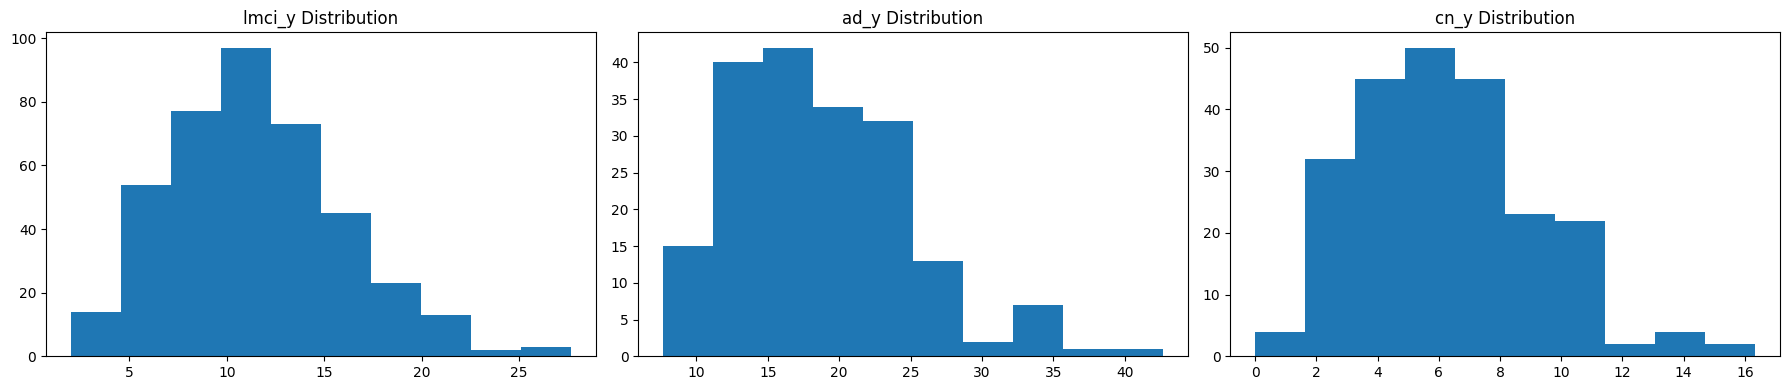

In [12]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 3 rows, 1 column, big figure size

# Plotting data1 in the first subplot
axes[0].hist(lmci_y)
axes[0].set_title('lmci_y Distribution')

# Plotting data2 in the second subplot
axes[1].hist(ad_y)
axes[1].set_title('ad_y Distribution')

# Plotting data3 in the third subplot
axes[2].hist(cn_y)
axes[2].set_title('cn_y Distribution')

# Adjusting layout
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5
X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.6661496723911483
CP train RSE:  0.0003328366478028351
Tucker train RSE:  0.0001434490040138438
mean test RSE:  1.1447560359477025
CP test RSE:  2.2759120638649
Tucker test RSE:  2.1283791440847315


In [8]:
model.print_tree()

  if X[:, 7 , 5 , 3 ] <=  1.7269168438613414
   if X[:, 4 , 7 , 8 ] <=  0.0698931760378182
     if X[:, 4 , 8 , 9 ] <=  0.03768671287596226
         has  0  child nodes, and  2  samples.
     else: # if X[:, 4 , 8 , 9 ] >  0.03768671287596226
         has  0  child nodes, and  87  samples.
   else: # if X[:, 4 , 7 , 8 ] >  0.0698931760378182
     if X[:, 10 , 7 , 3 ] <=  0.8018943796157837
         has  0  child nodes, and  8  samples.
     else: # if X[:, 10 , 7 , 3 ] >  0.8018943796157837
         has  0  child nodes, and  68  samples.
  else: # if X[:, 7 , 5 , 3 ] >  1.7269168438613414
   if X[:, 8 , 7 , 1 ] <=  3.0189043784737586
     if X[:, 5 , 6 , 8 ] <=  0.35621589033305645
         has  0  child nodes, and  106  samples.
     else: # if X[:, 5 , 6 , 8 ] >  0.35621589033305645
         has  0  child nodes, and  37  samples.
   else: # if X[:, 8 , 7 , 1 ] >  3.0189043784737586
     if X[:, 7 , 5 , 8 ] <=  3.9584479460716246
         has  0  child nodes, and  7  samples.
     els

In [41]:

X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.2, random_state=42)
X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train = X_train+np.random.randn(*X_train.shape) * 1e-3

# Initialize a list to hold the smaller tensors for each leaf node
leaf_nodes = []

# Condition 1: X[:, 7, 5, 3] <= 1.7269168438613414
mask_1 = X_train[:, 7, 5, 3] <= 1.7269168438613414

# Sub-condition 1.1: X[:, 4, 7, 8] <= 0.0698931760378182
mask_1_1 = mask_1 & (X_train[:, 4, 7, 8] <= 0.0698931760378182)

# Sub-condition 1.1.1: X[:, 4, 8, 9] <= 0.03768671287596226 (leaf node, 2 samples)
mask_1_1_1 = mask_1_1 & (X_train[:, 4, 8, 9] <= 0.03768671287596226)
leaf_nodes.append({
    'samples': X_train[mask_1_1_1],
    'labels': y_train[mask_1_1_1],
    'description': 'Leaf node 1.1.1 (2 samples)'
})

# Sub-condition 1.1.2: X[:, 4, 8, 9] > 0.03768671287596226 (leaf node, 87 samples)
mask_1_1_2 = mask_1_1 & (X_train[:, 4, 8, 9] > 0.03768671287596226)
leaf_nodes.append({
    'samples': X_train[mask_1_1_2],
    'labels': y_train[mask_1_1_2],
    'description': 'Leaf node 1.1.2 (87 samples)'
})

# Sub-condition 1.2: X[:, 4, 7, 8] > 0.0698931760378182
mask_1_2 = mask_1 & (X_train[:, 4, 7, 8] > 0.0698931760378182)

# Sub-condition 1.2.1: X[:, 10, 7, 3] <= 0.8018943796157837 (leaf node, 8 samples)
mask_1_2_1 = mask_1_2 & (X_train[:, 10, 7, 3] <= 0.8018943796157837)
leaf_nodes.append({
    'samples': X_train[mask_1_2_1],
    'labels': y_train[mask_1_2_1],
    'description': 'Leaf node 1.2.1 (8 samples)'
})

# Sub-condition 1.2.2: X[:, 10, 7, 3] > 0.8018943796157837 (leaf node, 68 samples)
mask_1_2_2 = mask_1_2 & (X_train[:, 10, 7, 3] > 0.8018943796157837)
leaf_nodes.append({
    'samples': X_train[mask_1_2_2],
    'labels': y_train[mask_1_2_2],
    'description': 'Leaf node 1.2.2 (68 samples)'
})

# Condition 2: X[:, 7, 5, 3] > 1.7269168438613414
mask_2 = X_train[:, 7, 5, 3] > 1.7269168438613414

# Sub-condition 2.1: X[:, 8, 7, 1] <= 3.0189043784737586
mask_2_1 = mask_2 & (X_train[:, 8, 7, 1] <= 3.0189043784737586)

# Sub-condition 2.1.1: X[:, 5, 6, 8] <= 0.35621589033305645 (leaf node, 106 samples)
mask_2_1_1 = mask_2_1 & (X_train[:, 5, 6, 8] <= 0.35621589033305645)
leaf_nodes.append({
    'samples': X_train[mask_2_1_1],
    'labels': y_train[mask_2_1_1],
    'description': 'Leaf node 2.1.1 (106 samples)'
})

# Sub-condition 2.1.2: X[:, 5, 6, 8] > 0.35621589033305645 (leaf node, 37 samples)
mask_2_1_2 = mask_2_1 & (X_train[:, 5, 6, 8] > 0.35621589033305645)
leaf_nodes.append({
    'samples': X_train[mask_2_1_2],
    'labels': y_train[mask_2_1_2],
    'description': 'Leaf node 2.1.2 (37 samples)'
})

# Sub-condition 2.2: X[:, 8, 7, 1] > 3.0189043784737586
mask_2_2 = mask_2 & (X_train[:, 8, 7, 1] > 3.0189043784737586)

# Sub-condition 2.2.1: X[:, 7, 5, 8] <= 3.9584479460716246 (leaf node, 7 samples)
mask_2_2_1 = mask_2_2 & (X_train[:, 7, 5, 8] <= 3.9584479460716246)
leaf_nodes.append({
    'samples': X_train[mask_2_2_1],
    'labels': y_train[mask_2_2_1],
    'description': 'Leaf node 2.2.1 (7 samples)'
})

# Sub-condition 2.2.2: X[:, 7, 5, 8] > 3.9584479460716246 (leaf node, 5 samples)
mask_2_2_2 = mask_2_2 & (X_train[:, 7, 5, 8] > 3.9584479460716246)
leaf_nodes.append({
    'samples': X_train[mask_2_2_2],
    'labels': y_train[mask_2_2_2],
    'description': 'Leaf node 2.2.2 (5 samples)'
})

# Display the results
for i, node in enumerate(leaf_nodes):
    print(f"Leaf Node {i+1}: {node['description']}, Samples Shape: {node['samples'].shape}, Labels Shape: {node['labels'].shape}")



Leaf Node 1: Leaf node 1.1.1 (2 samples), Samples Shape: (2, 12, 12, 12), Labels Shape: (2,)
Leaf Node 2: Leaf node 1.1.2 (87 samples), Samples Shape: (89, 12, 12, 12), Labels Shape: (89,)
Leaf Node 3: Leaf node 1.2.1 (8 samples), Samples Shape: (8, 12, 12, 12), Labels Shape: (8,)
Leaf Node 4: Leaf node 1.2.2 (68 samples), Samples Shape: (67, 12, 12, 12), Labels Shape: (67,)
Leaf Node 5: Leaf node 2.1.1 (106 samples), Samples Shape: (106, 12, 12, 12), Labels Shape: (106,)
Leaf Node 6: Leaf node 2.1.2 (37 samples), Samples Shape: (36, 12, 12, 12), Labels Shape: (36,)
Leaf Node 7: Leaf node 2.2.1 (7 samples), Samples Shape: (7, 12, 12, 12), Labels Shape: (7,)
Leaf Node 8: Leaf node 2.2.2 (5 samples), Samples Shape: (5, 12, 12, 12), Labels Shape: (5,)


In [43]:
# Parameters for tensor regression
nsweep = 100
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing

Skipping leaf node 1, as it has only 2 samples.
Training model for leaf node 2, with 89 samples
Time out: 13.256395101547241
Model trained for leaf node 2. Beta_est shape: (12, 12, 12)
Skipping leaf node 3, as it has only 8 samples.
Training model for leaf node 4, with 67 samples
Time out: 11.7952880859375
Model trained for leaf node 4. Beta_est shape: (12, 12, 12)
Training model for leaf node 5, with 106 samples
Time out: 14.045124053955078
Model trained for leaf node 5. Beta_est shape: (12, 12, 12)
Training model for leaf node 6, with 36 samples
Time out: 10.121175050735474
Model trained for leaf node 6. Beta_est shape: (12, 12, 12)
Skipping leaf node 7, as it has only 7 samples.
Skipping leaf node 8, as it has only 5 samples.
Leaf node 2 - Beta_est shape: (12, 12, 12), sample size: 89
Leaf node 4 - Beta_est shape: (12, 12, 12), sample size: 67
Leaf node 5 - Beta_est shape: (12, 12, 12), sample size: 106
Leaf node 6 - Beta_est shape: (12, 12, 12), sample size: 36


In [46]:
# Dictionary to store results, including errors
results = []

for i, node in enumerate(leaf_nodes):
    # Check if the sample size is greater than 10
    if node['samples'].shape[0] > 10:
        print(f"Training model for leaf node {i+1}, with {node['samples'].shape[0]} samples")

        # z_train is an array of zeros with length equal to the number of samples
        z_train = np.zeros((node['samples'].shape[0], 1))  # Zero-filled array for z_train
        X_train = node['samples']  # Replace this with the appropriate tensor feature data
        y_train = node['labels']

        # Run tensor_reg for this leaf node
        out = tensor_reg(
            z_train=z_train, 
            x_train=X_train, 
            y_train=y_train, 
            nsweep=nsweep, 
            rank=rank, 
            burn=burn, 
            nskip=nskip, 
            scale=True, 
            a_lam=None, 
            b_lam=None, 
            phi_alpha=None, 
            plot=True
        )

        # Compute Beta_mcmc
        Beta_mcmc = getBeta_mcmc(out['beta_store'])

        # Compute Beta_est
        p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]
        Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

        # Calculate relative error (RMSE) for this node
        err = 0
        for j in range(X_train.shape[0]):
            err += (np.tensordot(X_train[j], Beta_est, axes=((0, 1, 2), (0, 1, 2))) - y_train[j]) ** 2
        mse = err / X_train.shape[0]
        rmse = np.sqrt(mse) / np.var(y_train)

        # Store the result for this node, including the RMSE
        results.append({
            'leaf_node': i + 1,
            'Beta_mcmc': Beta_mcmc,
            'Beta_est': Beta_est,
            'rmse': rmse,
            'sample_size': node['samples'].shape[0]
        })

        print(f"Model trained for leaf node {i+1}. RMSE: {rmse}")
    else:
        print(f"Skipping leaf node {i+1}, as it has only {node['samples'].shape[0]} samples.")

# After the loop, you can access the results for each node
for result in results:
    print(f"Leaf node {result['leaf_node']} - RMSE: {result['rmse']}, sample size: {result['sample_size']}")


Skipping leaf node 1, as it has only 2 samples.
Training model for leaf node 2, with 89 samples
Time out: 13.267109870910645
Model trained for leaf node 2. RMSE: 0.8273919683399161
Skipping leaf node 3, as it has only 8 samples.
Training model for leaf node 4, with 67 samples
Time out: 11.872551202774048
Model trained for leaf node 4. RMSE: 1.177367175140335
Training model for leaf node 5, with 106 samples
Time out: 14.63814663887024
Model trained for leaf node 5. RMSE: 0.7866168291767057
Training model for leaf node 6, with 36 samples
Time out: 10.018769264221191
Model trained for leaf node 6. RMSE: 2.0979832028686918
Skipping leaf node 7, as it has only 7 samples.
Skipping leaf node 8, as it has only 5 samples.
Leaf node 2 - RMSE: 0.8273919683399161, sample size: 89
Leaf node 4 - RMSE: 1.177367175140335, sample size: 67
Leaf node 5 - RMSE: 0.7866168291767057, sample size: 106
Leaf node 6 - RMSE: 2.0979832028686918, sample size: 36


In [47]:
# Initialize a list to hold the smaller tensors for each leaf node in the test set
test_leaf_nodes = []

# Condition 1: X_test[:, 7, 5, 3] <= 1.7269168438613414
mask_1_test = X_test[:, 7, 5, 3] <= 1.7269168438613414

# Sub-condition 1.1: X_test[:, 4, 7, 8] <= 0.0698931760378182
mask_1_1_test = mask_1_test & (X_test[:, 4, 7, 8] <= 0.0698931760378182)

# Sub-condition 1.1.1: X_test[:, 4, 8, 9] <= 0.03768671287596226 (leaf node, 2 samples)
mask_1_1_1_test = mask_1_1_test & (X_test[:, 4, 8, 9] <= 0.03768671287596226)
test_leaf_nodes.append({
    'samples': X_test[mask_1_1_1_test],
    'labels': y_test[mask_1_1_1_test],
    'description': 'Test Leaf node 1.1.1'
})

# Sub-condition 1.1.2: X_test[:, 4, 8, 9] > 0.03768671287596226 (leaf node, 87 samples)
mask_1_1_2_test = mask_1_1_test & (X_test[:, 4, 8, 9] > 0.03768671287596226)
test_leaf_nodes.append({
    'samples': X_test[mask_1_1_2_test],
    'labels': y_test[mask_1_1_2_test],
    'description': 'Test Leaf node 1.1.2'
})

# Sub-condition 1.2: X_test[:, 4, 7, 8] > 0.0698931760378182
mask_1_2_test = mask_1_test & (X_test[:, 4, 7, 8] > 0.0698931760378182)

# Sub-condition 1.2.1: X_test[:, 10, 7, 3] <= 0.8018943796157837 (leaf node, 8 samples)
mask_1_2_1_test = mask_1_2_test & (X_test[:, 10, 7, 3] <= 0.8018943796157837)
test_leaf_nodes.append({
    'samples': X_test[mask_1_2_1_test],
    'labels': y_test[mask_1_2_1_test],
    'description': 'Test Leaf node 1.2.1'
})

# Sub-condition 1.2.2: X_test[:, 10, 7, 3] > 0.8018943796157837 (leaf node, 68 samples)
mask_1_2_2_test = mask_1_2_test & (X_test[:, 10, 7, 3] > 0.8018943796157837)
test_leaf_nodes.append({
    'samples': X_test[mask_1_2_2_test],
    'labels': y_test[mask_1_2_2_test],
    'description': 'Test Leaf node 1.2.2'
})

# Condition 2: X_test[:, 7, 5, 3] > 1.7269168438613414
mask_2_test = X_test[:, 7, 5, 3] > 1.7269168438613414

# Sub-condition 2.1: X_test[:, 8, 7, 1] <= 3.0189043784737586
mask_2_1_test = mask_2_test & (X_test[:, 8, 7, 1] <= 3.0189043784737586)

# Sub-condition 2.1.1: X_test[:, 5, 6, 8] <= 0.35621589033305645 (leaf node, 106 samples)
mask_2_1_1_test = mask_2_1_test & (X_test[:, 5, 6, 8] <= 0.35621589033305645)
test_leaf_nodes.append({
    'samples': X_test[mask_2_1_1_test],
    'labels': y_test[mask_2_1_1_test],
    'description': 'Test Leaf node 2.1.1'
})

# Sub-condition 2.1.2: X_test[:, 5, 6, 8] > 0.35621589033305645 (leaf node, 37 samples)
mask_2_1_2_test = mask_2_1_test & (X_test[:, 5, 6, 8] > 0.35621589033305645)
test_leaf_nodes.append({
    'samples': X_test[mask_2_1_2_test],
    'labels': y_test[mask_2_1_2_test],
    'description': 'Test Leaf node 2.1.2'
})

# Sub-condition 2.2: X_test[:, 8, 7, 1] > 3.0189043784737586
mask_2_2_test = mask_2_test & (X_test[:, 8, 7, 1] > 3.0189043784737586)

# Sub-condition 2.2.1: X_test[:, 7, 5, 8] <= 3.9584479460716246 (leaf node, 7 samples)
mask_2_2_1_test = mask_2_2_test & (X_test[:, 7, 5, 8] <= 3.9584479460716246)
test_leaf_nodes.append({
    'samples': X_test[mask_2_2_1_test],
    'labels': y_test[mask_2_2_1_test],
    'description': 'Test Leaf node 2.2.1'
})

# Sub-condition 2.2.2: X_test[:, 7, 5, 8] > 3.9584479460716246 (leaf node, 5 samples)
mask_2_2_2_test = mask_2_2_test & (X_test[:, 7, 5, 8] > 3.9584479460716246)
test_leaf_nodes.append({
    'samples': X_test[mask_2_2_2_test],
    'labels': y_test[mask_2_2_2_test],
    'description': 'Test Leaf node 2.2.2'
})

# Display the results for test set
for i, node in enumerate(test_leaf_nodes):
    print(f"Test Leaf Node {i+1}: {node['description']}, Samples Shape: {node['samples'].shape}, Labels Shape: {node['labels'].shape}")


Test Leaf Node 1: Test Leaf node 1.1.1, Samples Shape: (0, 12, 12, 12), Labels Shape: (0,)
Test Leaf Node 2: Test Leaf node 1.1.2, Samples Shape: (23, 12, 12, 12), Labels Shape: (23,)
Test Leaf Node 3: Test Leaf node 1.2.1, Samples Shape: (2, 12, 12, 12), Labels Shape: (2,)
Test Leaf Node 4: Test Leaf node 1.2.2, Samples Shape: (16, 12, 12, 12), Labels Shape: (16,)
Test Leaf Node 5: Test Leaf node 2.1.1, Samples Shape: (28, 12, 12, 12), Labels Shape: (28,)
Test Leaf Node 6: Test Leaf node 2.1.2, Samples Shape: (7, 12, 12, 12), Labels Shape: (7,)
Test Leaf Node 7: Test Leaf node 2.2.1, Samples Shape: (3, 12, 12, 12), Labels Shape: (3,)
Test Leaf Node 8: Test Leaf node 2.2.2, Samples Shape: (2, 12, 12, 12), Labels Shape: (2,)


In [48]:
# Dictionary to store test results, including errors
test_results = []

# Loop through the results from the training phase and apply them to the test data
for i, result in enumerate(results):
    # Find the corresponding test node (assuming the order matches between train and test)
    test_node = test_leaf_nodes[i]

    # Use the Beta_est from training
    Beta_est = result['Beta_est']
    X_test = test_node['samples']  # Test samples for the corresponding node
    y_test = test_node['labels']   # Test labels for the corresponding node

    # Calculate predicted values and relative error (RMSE) for this test node
    err = 0
    for j in range(X_test.shape[0]):
        predicted_value = np.tensordot(X_test[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
        err += (predicted_value - y_test[j]) ** 2
    mse = err / X_test.shape[0] if X_test.shape[0] > 0 else np.nan  # Handle case with no samples
    rmse = np.sqrt(mse) / np.var(y_test) if np.var(y_test) > 0 else np.nan  # Handle variance edge cases

    # Store the test result, including the RMSE
    test_results.append({
        'leaf_node': result['leaf_node'],
        'rmse': rmse,
        'sample_size': X_test.shape[0]
    })

    print(f"Test RMSE for leaf node {result['leaf_node']}: {rmse}")

# After the loop, you can access the results for each test node
for test_result in test_results:
    print(f"Test Leaf node {test_result['leaf_node']} - Test RMSE: {test_result['rmse']}, sample size: {test_result['sample_size']}")


Test RMSE for leaf node 2: nan
Test RMSE for leaf node 4: 0.8814856696292109
Test RMSE for leaf node 5: 2.789346666898399
Test RMSE for leaf node 6: 2.0303151451868158
Test Leaf node 2 - Test RMSE: nan, sample size: 0
Test Leaf node 4 - Test RMSE: 0.8814856696292109, sample size: 23
Test Leaf node 5 - Test RMSE: 2.789346666898399, sample size: 2
Test Leaf node 6 - Test RMSE: 2.0303151451868158, sample size: 16


In [15]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5
X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.min
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.9963371152213625
CP train RSE:  0.9962944858192141
Tucker train RSE:  0.9962933128414942
mean test RSE:  0.8856632351504014
CP test RSE:  7.177569757735098
Tucker test RSE:  7.177630256588527


In [16]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5
X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.sum
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.6661496723911483
CP train RSE:  3.4349786378264703e-05
Tucker train RSE:  2.0667959953642558e-05
mean test RSE:  1.1896976580496539
CP test RSE:  2.255613223889068
Tucker test RSE:  2.1889356342403525


In [17]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, lmci_y, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5
X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.median
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_train))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.7098757202280661
CP train RSE:  0.00017612500428918927
Tucker train RSE:  8.283606482577344e-05
mean test RSE:  1.065739198206284
CP test RSE:  2.3129099613767967
Tucker test RSE:  2.2532195918751357
